In [47]:
# scale the position by C / sigma^2
# volatility is estimated by monthly realized variance
# position is rebalanced monthly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import talib
import yfinance as yf

from scipy.optimize import brentq

sns.set(style='darkgrid', context='talk', palette='Dark2')

# my_year_month_fmt = mdates.DateFormatter('%m/%y')

In [64]:
data = yf.download("SPY", start="1900-01-01", end="2020-12-31")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


In [106]:
data.index = pd.to_datetime(data.index)
# data = data.set_index('datetime')
data = pd.DataFrame(data.loc[:, 'Adj Close'])
data.tail()

,Adj Close
Date,
2020-05-11,292.500000
2020-05-12,286.670013
2020-05-13,281.600006
2020-05-14,284.970001
2020-05-15,286.279999


In [99]:
# separate the whole data sample to training data set and testing data set
train_start_date = '2000-01-01'
train_end_date = '2010-12-31'
test_start_date = '2011-01-01'
test_end_date = '2020-12-31'
train_mask = (data.index >= train_start_date) & (data.index <= train_end_date)
test_mask = (data.index >= test_start_date) & (data.index <= test_end_date)
train_data = data.loc[train_mask]
test_data = data.loc[test_mask]

In [100]:
def vol_managed_portfolio(sample_data, *argv):
    
    # calculate log_return
    sample_data['log_return'] = np.log(sample_data['Adj Close']).diff()
    sample_data.dropna(inplace=True)
    
    # calculate the monthly variance and return
    sample_data['month'] = sample_data.index.to_period('M')
    monthly_log_variance = sample_data.groupby('month')['log_return'].var()
    monthly_log_return = sample_data.groupby('month')['log_return'].sum()
    
    
    # calculate the constant scaling factor
    adjusted_monthly_log_return = monthly_log_return.copy()

    def calculate_scaling_factor(c):
        adjusted_monthly_log_return[1:] = c / np.array(monthly_log_variance[:-1]) * np.array(monthly_log_return[1:])
        return adjusted_monthly_log_return.var() - monthly_log_return.var()

#     x = np.linspace(0, 0.0001, 50)
#     plt.plot(x, [calculate_scaling_factor(i) for i in x])
#     plt.axhline(color = 'r')

    # check whether c is given
    if argv:
        c = argv
    else:
        root, info = brentq(calculate_scaling_factor, 0, 1, full_output=True)
        c = root
#     print(root, info)

    adjusted_monthly_log_return[1:] = c / np.array(monthly_log_variance[:-1]) * np.array(monthly_log_return[1:])

    # get the cumulative log-returns
    cum_adjusted_log_returns = adjusted_monthly_log_return.cumsum()
    cum_log_returns = monthly_log_return.cumsum()

    # transform the cumulative log returns to relative returns
    cum_adjusted_returns = np.exp(cum_adjusted_log_returns) - 1
    cum_returns = np.exp(cum_log_returns) -1
    
    # plot cumulative returns
    fig, ax = plt.subplots(figsize=(16,9))

    x = cum_adjusted_returns.index.to_timestamp()
    ax.plot(x, cum_adjusted_returns.values, label='Adjusted')
    ax.plot(x, cum_returns.values, label='Not Adjusted')

    ax.legend(loc='best')

    print(adjusted_monthly_log_return.mean() / adjusted_monthly_log_return.std() * np.sqrt(252))
    print(monthly_log_return.mean() / monthly_log_return.std() * np.sqrt(252))

/Users/xiaomanli/python-apps/trading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/xiaomanli/python-apps/trading/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/xiaomanli/python-apps/trading/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

1.96702167363348
0.22371155954271663


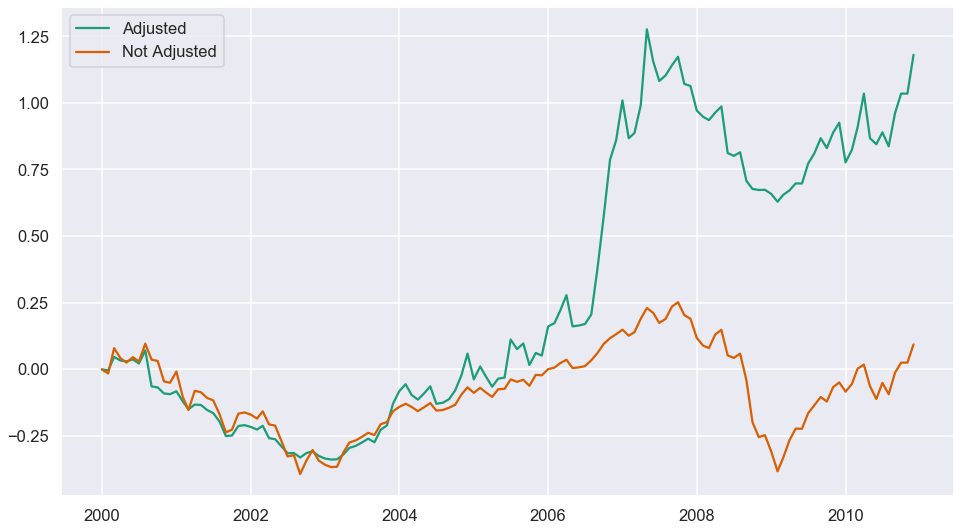

In [103]:
vol_managed_portfolio(train_data)

/Users/xiaomanli/python-apps/trading/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/xiaomanli/python-apps/trading/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/xiaomanli/python-apps/trading/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

3.045356043398723
3.709147454477091


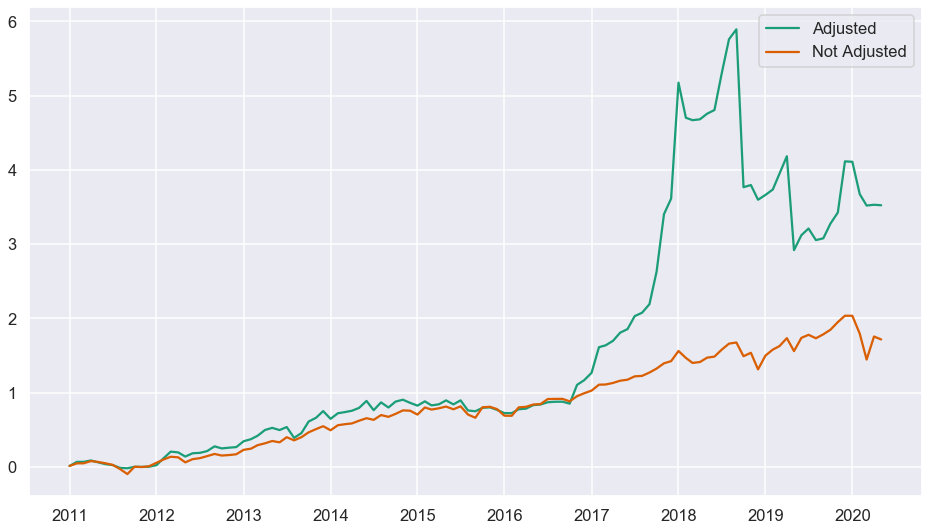

In [104]:
vol_managed_portfolio(test_data, c)

In [105]:
c

6.387678971555763e-05